In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter

In [7]:
import glob
vec_path = glob.glob("../data/vecs/abo16-an*.pkl")[0]
vec_path

'../data/vecs/abo16-an-02.vec.pkl'

In [8]:
with open(vec_path, "rb") as fin:
    evals = pickle.load(fin)

In [30]:
ans = evals["ans"]
ans_lst = sorted(set(ans))
ans_lst.remove('misc')
preds = evals["preds"]
mask = np.array([((x == y) and (x != "misc")) for x, y in zip(ans, preds)])

hlast = evals["last"][mask, :]
h0 = evals["h0"][mask, :]
h6 = evals["h6"][mask, :]
ans = np.array(ans)[mask]

In [31]:
len(hlast)

1871

## PCA

cumulative variance 0.5918067


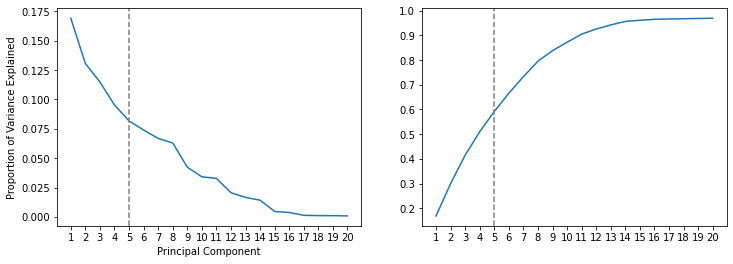

In [32]:
from sklearn.decomposition import PCA
pca = PCA(20)
K = 5
pca.fit(hlast)
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(20)+1, pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
_ = plt.gca().set_xticks(np.arange(20)+1)
plt.axvline(K, linestyle='--', color='gray')
plt.subplot(1, 2, 2)
cumvar = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(20)+1, cumvar)
print("cumulative variance", cumvar[K-1])
plt.axvline(K, linestyle='--', color='gray')
_ = plt.gca().set_xticks(np.arange(20)+1)

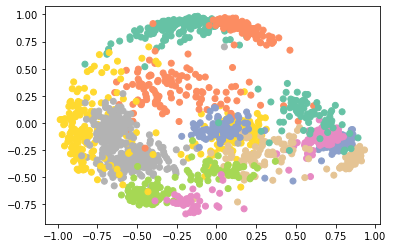

In [33]:
pca2 = PCA(K)
hlast_proj = pca2.fit_transform(hlast)
hlast_norm = hlast_proj / np.linalg.norm(hlast_proj, axis=1)[:, np.newaxis]
ans_idx = [ans_lst.index(x) for x in ans]
plt.scatter(hlast_norm[:, 0], hlast_norm[:, 1], c=ans_idx, cmap="Set2")

In [34]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
medoids = []
for ans_x in ans_lst:
    mat = hlast_norm[ans==ans_x]    
    D = squareform(pdist(mat, metric='cosine'))
    med_idx = np.argmin(D.sum(axis=0))
    medoids.append(mat[med_idx])

In [35]:
len(medoids)

16

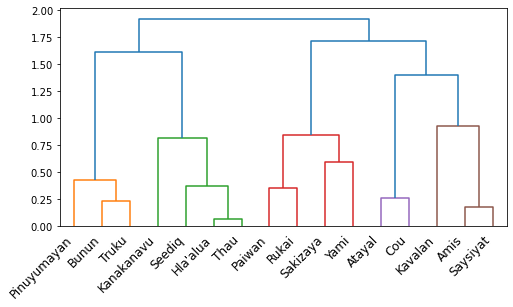

In [36]:
plt.figure(figsize=(8,4))
Dm = pdist(medoids, metric='cosine')
Zm = linkage(Dm, method='complete')
dendrogram(Zm, labels=ans_lst, leaf_rotation=45)
xlabels = plt.gca().get_xticklabels()
_ = plt.gca().set_xticklabels(xlabels, ha='right')

## Compute LDA

In [37]:
feat_phones = pd.read_csv("../data/langfeats/feat_phones.csv", index_col=0)

In [38]:
from scipy.stats import entropy
feat_mat = np.array(feat_phones)
p = (feat_mat==1).sum(axis=0)/12
log2p = lambda x: [np.log2(p) if p>0 else 0 for p in x]
feat_entropies = -p*log2p(p)-(1-p)*log2p(1-p)
feat_entropies_orders = feat_entropies.argsort()[::-1]

In [39]:
p=np.array([0.75]);-p*log2p(p)-(1-p)*log2p(1-p)

array([0.81127812])

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
feat_ldas = []
for feat_idx in feat_entropies_orders:    
    feat_ent = feat_entropies[feat_idx]
    if feat_ent < 0.8113: continue
    
    feat_x = feat_phones.iloc[:, feat_idx]
    feat_name = feat_x.name
    ymap = feat_x.to_dict()
    
    lda = LinearDiscriminantAnalysis()            
    y = [ymap.get(x,0) for x in ans]
    lda.fit(hlast_proj, y)
    score = lda.score(hlast_norm, y)
    coefs = lda.coef_[0]
    intc = lda.intercept_[0]
    feat_ldas.append(dict(
        feat_name=feat_name, 
        feat_ent=feat_ent,
        score=score,
        coefs=coefs, intc=intc
    ))

In [41]:
len(feat_ldas)

31

15 left, with score cutpoint set to  0.6910742918225548


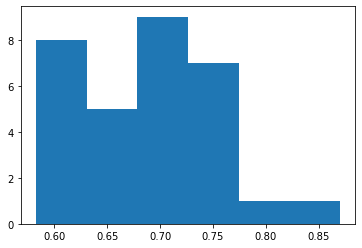

In [42]:
plt.hist([x["score"] for x in feat_ldas], 6)
score_q2 = np.quantile([x["score"] for x in feat_ldas], 0.5)
feat_q2 = len([x["score"] for x in feat_ldas if x["score"] > score_q2])
print(feat_q2, "left, with score cutpoint set to ", score_q2)

In [43]:
lda_subs = [x for x in feat_ldas if x["score"] > score_q2]
coefs = np.vstack([x["coefs"] for x in lda_subs])

In [44]:
np.set_printoptions(precision=2)
for ki in range(K):    
    print("----", ki, "-----")
    order_ki = np.argsort(coefs[:, ki])[::-1]
    pos_inst = lda_subs[order_ki[0]]
    print(f"Positive: {pos_inst['feat_name']}, ({pos_inst['coefs'][ki]:.2f})")
    print(f"          lda score: {pos_inst['score']:.2f}")
    print(f"          {pos_inst['coefs']}")
    neg_inst = lda_subs[order_ki[-1]]
    print(f"Negative: {neg_inst['feat_name']}, ({neg_inst['coefs'][ki]:.2f})")
    print(f"          lda score: {neg_inst['score']:.2f}")
    print(f"          {neg_inst['coefs']}")
np.set_printoptions(precision=8)

---- 0 -----
Positive: voicelessalveolarlateralfricative, (0.84)
          lda score: 0.76
          [ 0.84 -0.18  0.14 -0.55 -0.39]
Negative: Velarvoicedplosive, (-0.52)
          lda score: 0.75
          [-0.52 -0.94 -0.14  0.93 -0.46]
---- 1 -----
Positive: Midfrontvowel, (0.88)
          lda score: 0.72
          [0.07 0.88 0.24 0.29 0.18]
Negative: Velarvoicedplosive, (-0.94)
          lda score: 0.75
          [-0.52 -0.94 -0.14  0.93 -0.46]
---- 2 -----
Positive: Alveolarvoicedfricative, (1.52)
          lda score: 0.73
          [ 0.08 -0.86  1.52  0.13 -1.3 ]
Negative: Labialdentalvoicedfricative, (-0.21)
          lda score: 0.79
          [-0.06  0.19 -0.21  0.16  0.11]
---- 3 -----
Positive: Velarvoicedplosive, (0.93)
          lda score: 0.75
          [-0.52 -0.94 -0.14  0.93 -0.46]
Negative: voicelessalveolarlateralfricative, (-0.55)
          lda score: 0.76
          [ 0.84 -0.18  0.14 -0.55 -0.39]
---- 4 -----
Positive: voiceddentalnonsibilantfricative, (0.54)
      

In [45]:
np.set_printoptions(precision=2)
for lang, med in zip(ans_lst, medoids):
    print("{:12s} {}".format(lang, med))
np.set_printoptions(precision=8)

Amis         [0.59 0.06 0.75 0.08 0.27]
Atayal       [-0.2   0.93  0.29  0.12  0.01]
Bunun        [-0.27  0.35 -0.55 -0.63  0.33]
Cou          [ 0.16  0.89 -0.29  0.27 -0.14]
Hla'alua     [ 0.76 -0.2  -0.44  0.39  0.19]
Kanakanavu   [ 0.05 -0.04 -0.39  0.31  0.86]
Kavalan      [ 0.68 -0.13  0.17 -0.52 -0.47]
Paiwan       [-0.12 -0.76  0.44  0.45  0.09]
Pinuyumayan  [ 0.02 -0.44 -0.59 -0.56  0.39]
Rukai        [-0.47 -0.65 -0.19  0.3   0.47]
Sakizaya     [-0.91 -0.08  0.25 -0.29  0.09]
Saysiyat     [ 0.1  -0.07  0.87 -0.11  0.45]
Seediq       [ 0.26 -0.28 -0.89  0.22 -0.09]
Thau         [ 0.87 -0.31 -0.28  0.25 -0.07]
Truku        [-0.65 -0.03 -0.37 -0.66 -0.04]
Yami         [-0.55 -0.36  0.25  0.47 -0.54]
